# Introduction to Neural Networks 


** Ecole Centrale Nantes **

** Diana Mateus **


** Participants : Orane VERNET, Diane CHOUNLAMOUNTRY**



## General description
In this lab we will create a simple classifier based on neural networks. We will progress in two parts:
- In the first part, and to better understand the involved operations, we will create a single-neuron model and optimize its parameters "by hand". For this first part we will only use the **Numpy** library
- We will then build a CNN with the built-in **Keras** module from **tensorflow**. Tensorflow is already installed in the university computers. If using your own computer you should have already installed **tensorflow** or use **collab** online platform.




In [24]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Loading the dataset
Start by runing the following lines to load and visualize the data.

In [25]:
# UNCOMMENT IF USING COLAB
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = '//data-pfe/overnet2022/EI2/APSTA/TP4/'
IMDIR = '//data-pfe/dchounlamo2022/CENTRALE_EI2/APSTA/TP4/TP4/'

In [26]:
def load_dataset(IMDIR):
    train_dataset = h5py.File(IMDIR+'dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) 
    train_y = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File(IMDIR+'dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) 
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)

#### Visualize data

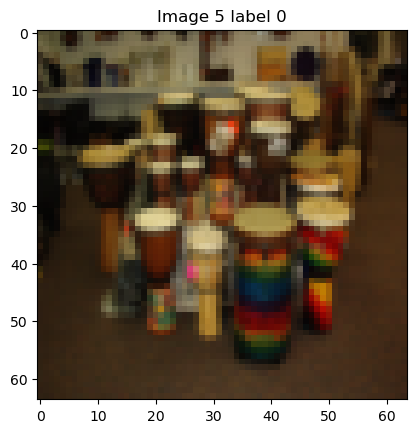

Train X shape: (209, 64, 64, 3)
We have 209 images of dimensionality 64x64x3


In [36]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)
index = np.random.randint(low=0,high=train_y.shape[1])
plt.imshow(train_x[index])
plt.title("Image "+str(index)+" label "+str(train_y[0,index]))
plt.show()
print ("Train X shape: " + str(train_x.shape))
print ("We have "+str(train_x.shape[0]), 
       "images of dimensionality " 
       + str(train_x.shape[1])+ "x"
       + str(train_x.shape[2])+ "x"
       + str(train_x.shape[3]))

#### Preprocessing
In the following lines we vectorize the images (Instead of a 2-D image we will give as input to the models a 1-D vector). The normalization makes the image intensities be between 0 and 1, and converts the images to floats.

In [22]:
train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)
print ("Original train X shape: " + str(train_x.shape))
print ("Original test X shape: " + str(test_x.shape))
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(train_y.shape))
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Original train X shape: (209, 64, 64, 3)
Original test X shape: (50, 64, 64, 3)
Train X shape: (12288, 209)
Train Y shape: (1, 209)
Test X shape: (12288, 50)
Test Y shape: (1, 50)


In [13]:
train_x = train_x/255.
test_x = test_x/255.

### 1. Classification with a single neuron 


**a)** Fill-in the following three functions to define the single neuron model (a single neuron in the hidden layer):
- A function **initialize_parameters**, which given the number of desired weights ```dim```  it inizializes the neuron parameters.  
> The function will initialize:
> * the model's weights $\mathbf{w}$ by randomly, by sampling small values from a normal distribution (**Hint:** np.random.randn). 
> * the bias $b$ with 0. 
What is the number of weights required? pass this information as a parameter to the function.
- A function **sigmoid** that computes the sigmoid activation function
- A function **neuron** that given an input vector, the weights and bias, computes the output of the single neuron model

In [14]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [15]:
def initialize_parameters(dim):
    w = np.random.randn(dim)/100
    b = 0
    return w, b

In [16]:
def neuron(w,b,x):
    pred_y=sigmoid(w.T@x+b)
    return pred_y

**b)** **Forward Pass:**
Use the three functions above to compute a first forward pass for the input matrix $X$ containing the loaded dataset, for some initialization of the weights and bias.
 
 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}
 

In [19]:
dim = train_x.shape[0]
w,b = initialize_parameters(dim)
pred_y=neuron(w,b,train_x)
pred_y = pred_y.reshape((1,train_y.shape[1]))
print(np.shape(pred_y))
print(np.shape(train_y))

(1, 209)
(1, 209)


**c) Cost estimation:**
 
We will use a binary cross-entropy loss, so that the empirical risk can be computed as:
 \begin{align}
 E = - \frac{1}{m} \sum_{i=1}^m 
 y^{(i)} \log(y_{\rm pred}^{(i)}) +
 (1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
 \end{align}
 
 The following cross-entropy function should give as result the **scalar** cost value computed over the entire dataset

In [179]:
def crossentropy(train_y,pred_y):

    m = pred_y.shape[0]
    somme=0
    for i in range(m):
        somme += train_y[0,i]*np.log(pred_y[i]+1e-10) + (1-train_y[0,i])*np.log(1-pred_y[i]+1e-10)
        
    cost = -(1/m)*somme
    
    return cost 

crossentropy(train_y,pred_y)

0.6608533722264552

**d) Back propagation:**

After initializing the parameters and doing a forward pass, we need to backpropagate the cost by computing the gradient with respect to the model parameters to later update the weights

\begin{align}
\frac{\partial E}{\partial w} = \\
\frac{\partial E}{\partial b} = 
\end{align}

See a demonstration of the gradient computation in 
https://en.wikipedia.org/wiki/Cross_entropy

Fill-in the backpropagation function which receives as input the the training set (X,Y), as well as the current predictions and returns the gradients updates for the weights and bias

Hint: When the error is computed for several samples simultaneously, the gradient is averaged over the contribution of different samples.


In [180]:
def backpropagate(X, Y, Ypred):
    m = X.shape[1]
    
    
    #find gradient (back propagation)
    #E=crossentropy(Y,Ypred)
    #dw = np.dot(X,(Ypred -Y).T)
    dw=X@(Ypred-Y).T
    db = np.sum(Ypred-Y)
    grads = {"dw": dw,
             "db": db} 
    
    return grads


**e) Optimization**
After initializing the parameters, computing the cost function, and calculating gradients, we can now update the parameters using gradient descent. Use the functions implemented above to fill_in the "gradient_descent" function that optimizes the parameters given a training set X, Y, a fixed number of iterations, and a learning_rate. Store and plot the value of the loss function at each iteration

In [181]:
def gradient_descent(X, Y, iterations, learning_rate):
    costs = []
    w, b = initialize_parameters(train_x.shape[0])
    
    for i in range(iterations):
        Ypred = neuron(w,b,X)
        cost = crossentropy(Y, Ypred)
        grads = backpropagate(X, Y, Ypred)
        
        #update parameters
        w = w-learning_rate*grads["dw"][:,0]
        b = b-learning_rate*grads["db"]
        costs.append(cost)
        
       # if i % 100 == 0:
           # print ("Cost after iteration %i: %f" %(i, cost))
       
    return w,b, costs

w, b, costs = gradient_descent(train_x,train_y,iterations=2000, learning_rate = 0.00001)

**f) Plot the training loss curve**
Plot the evolution of the loss against the iterations 

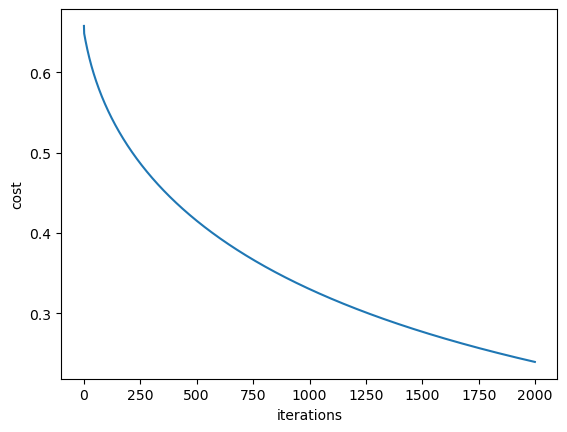

In [182]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

**g) Prediction**
Use the optimized parameters to make predictions both for the train and test sets and compute the accuracy for each. What do you observe?

Train Acc: 99.96625779967634 %
Test Acc: 69.58544457575078 %


Text(0.5, 1.0, 'Train')

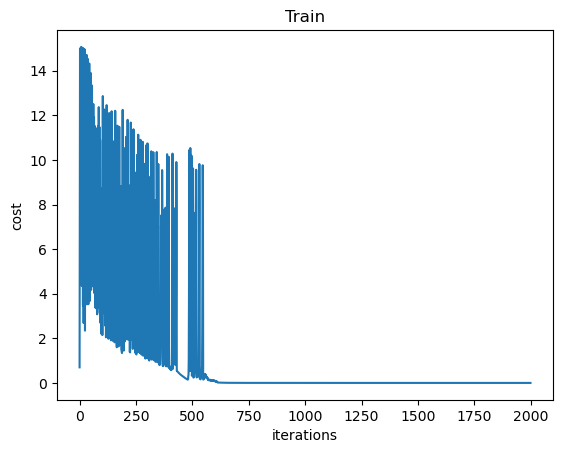

In [193]:
def predict(w, b, X):  
    
    y_pred = neuron(w,b,X)
    

    return y_pred

# predict 
w_train, b_train, costs_train = gradient_descent(train_x,train_y,iterations=2000, learning_rate = 0.001)
train_pred_y = predict(w_train, b_train, train_x)
test_pred_y = predict(w_train, b_train, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))


plt.plot(costs_train)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Train')

    
    

**h)Choose learning rate on a validation set** Use 10% of the training data as validation to choose the learning rate. What are the best results you can obtain? (use only the validation data to choose, buy repport the accuracy on the train and test data)


Train Acc: 62.43561787707189 %
0.5558442997322762
Train Acc: 60.16997345139922 %


Text(0.5, 1.0, 'Cout sur les 10% test du training set')

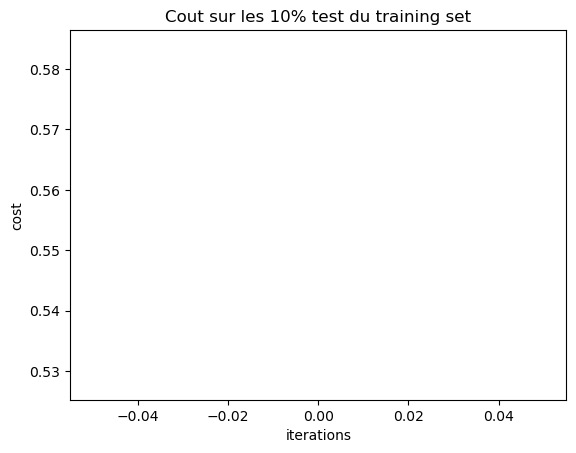

In [201]:
pourcentage = int(np.floor(0.9*209))

xtrain_valid=train_x[:,:pourcentage]
ytrain_valid=train_y[:,:pourcentage]

x_test=train_x[:,pourcentage:]
y_test=train_y[:,pourcentage:]

#lambda = linspace (0,0.001,1000)
w_valid, b_valid, costs_valid = gradient_descent(xtrain_valid,ytrain_valid,iterations=2000, learning_rate = 0.000001)



#avec le set d'entraînement
train_pred_y_valid = predict(w_valid, b_valid, xtrain_valid)


print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y_valid - ytrain_valid)) * 100))
#plt.subplot(2,1,1)
#plt.plot(costs_valid)
#plt.ylabel('cost')
#plt.xlabel('iterations')
#plt.title('Cout sur les 90% du training set')



#avec les 10% restants pour tester

train_pred_y_test = predict(w_valid,b_valid,xtrain_test)

costs_test = crossentropy(ytrain_test,train_pred_y_test)
print(costs_test)

print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y_test - ytrain_test)) * 100))
#plt.subplot(2,1,2)
plt.plot(costs_test)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Cout sur les 10% test du training set')





#on prend les 90% restants pour l'entraînement
#mettre des courbes pour savoir si c'est sous-apprentissage, sur-apprentissage etc et pour validation croisée, 
#on va trouver des courbes différenes pour les courbes d'entraînement et els courbes de validation